In [1]:
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN
from tensorflow.keras.optimizers import Adam


In [2]:
def load_data(battery):
    mat = loadmat('C:/LEE/batterydata/' + battery + '.mat')
    print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
    counter = 0
    dataset = []
    capacity_data = []

    for i in range(len(mat[battery][0, 0]['cycle'][0])):
        row = mat[battery][0, 0]['cycle'][0, i]
        if row['type'][0] == 'discharge':
            ambient_temperature = row['ambient_temperature'][0][0]
            date_time = datetime.datetime(int(row['time'][0][0]),
                                    int(row['time'][0][1]),
                                    int(row['time'][0][2]),
                                    int(row['time'][0][3]),
                                    int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
            data = row['data']
            capacity = data[0][0]['Capacity'][0][0]
            for j in range(len(data[0][0]['Voltage_measured'][0])):
                voltage_measured = data[0][0]['Voltage_measured'][0][j]
                current_measured = data[0][0]['Current_measured'][0][j]
                temperature_measured = data[0][0]['Temperature_measured'][0][j]
                current_load = data[0][0]['Current_load'][0][j]
                voltage_load = data[0][0]['Voltage_load'][0][j]
                time = data[0][0]['Time'][0][j]
                dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                                voltage_measured, current_measured,
                                temperature_measured, current_load,
                                voltage_load, time])
            capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
            counter = counter + 1
    return [pd.DataFrame(data=dataset,
                        columns=['cycle', 'ambient_temperature', 'datetime',
                                 'capacity', 'voltage_measured',
                                 'current_measured', 'temperature_measured',
                                 'current_load', 'voltage_load', 'time']),
            pd.DataFrame(data=capacity_data,
                        columns=['cycle', 'ambient_temperature', 'datetime',
                                 'capacity'])]

dataset, capacity = load_data('B0005')
pd.set_option('display.max_columns', 10)
print(dataset.head())
dataset.describe()

Total data in dataset:  616
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  1.856487          4.191492   
1      1                   24 2008-04-02 15:25:41  1.856487          4.190749   
2      1                   24 2008-04-02 15:25:41  1.856487          3.974871   
3      1                   24 2008-04-02 15:25:41  1.856487          3.951717   
4      1                   24 2008-04-02 15:25:41  1.856487          3.934352   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.004902             24.330034       -0.0006         0.000   0.000  
1         -0.001478             24.325993       -0.0006         4.206  16.781  
2         -2.012528             24.389085       -1.9982         3.062  35.703  
3         -2.013979             24.544752       -1.9982         3.030  53.781  
4         -2.011144             24.731385       -1.9982         3.011  71.922  


,cycle,ambient_temperature,datetime,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
count,50285.000000,50285.0,50285,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000
mean,88.125942,24.0,2008-05-07 01:58:43.570826240,1.560345,3.515268,-1.806032,32.816991,1.362700,2.308406,1546.208924
min,1.000000,24.0,2008-04-02 15:25:41,1.287453,2.455679,-2.029098,23.214802,-1.998400,0.000000,0.000000
25%,50.000000,24.0,2008-04-29 22:00:04,1.386229,3.399384,-2.013415,30.019392,1.998000,2.388000,768.563000
50%,88.000000,24.0,2008-05-07 21:56:09,1.538237,3.511664,-2.012312,32.828944,1.998200,2.533000,1537.031000
75%,127.000000,24.0,2008-05-18 03:05:19,1.746871,3.660903,-2.011052,35.920887,1.998200,2.690000,2305.984000
max,168.000000,24.0,2008-05-27 20:45:42,1.856487,4.222920,0.007496,41.450232,1.998400,4.238000,3690.234000
std,45.699687,0.0,NaN,0.182380,0.231778,0.610502,3.987515,1.313698,0.800300,906.640295


In [3]:
# SoH 계산
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity'])/C
print(dis_ele.head(5))

# 데이터 정규화
attribs=['capacity', 'voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
train_dataset = dataset[attribs]
sc = MinMaxScaler(feature_range=(0,1))
train_dataset = sc.fit_transform(train_dataset)

# 데이터 분할 및 변환
dataset_val, capacity_val = load_data('B0005')
data_train = capacity_val[(capacity_val['cycle'] < 50)].iloc[:, 1:2].values
data_test = capacity_val[(capacity_val['cycle'] >= 50)].iloc[:, 1:2].values

sc = MinMaxScaler(feature_range=(0,1))
data_train = sc.fit_transform(data_train)
data_test = sc.transform(data_test)

   cycle            datetime  capacity       SoH
0      1 2008-04-02 15:25:41  1.856487  1.000000
1      2 2008-04-02 19:43:48  1.846327  0.994527
2      3 2008-04-03 00:01:06  1.835349  0.988614
3      4 2008-04-03 04:16:37  1.835263  0.988567
4      5 2008-04-03 08:33:25  1.834646  0.988235
Total data in dataset:  616


In [4]:
# 학습 데이터 준비
X_train = []
y_train = []
for i in range(10, 49):
    X_train.append(data_train[i-10:i, 0])
    y_train.append(data_train[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# RNN 모델 구축
regress = Sequential()
regress.add(SimpleRNN(units=200, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regress.add(Dropout(0.4))
regress.add(SimpleRNN(units=200, return_sequences=True))
regress.add(Dropout(0.4))
regress.add(SimpleRNN(units=200, return_sequences=True))
regress.add(Dropout(0.4))
regress.add(SimpleRNN(units=200))
regress.add(Dropout(0.4))
regress.add(Dense(units=1))
regress.compile(optimizer='adam', loss='mean_squared_error')
regress.summary()

# 모델 학습
regress.fit(X_train, y_train, epochs=200, batch_size=25)

c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 10, 200)        │        40,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 10, 200)        │        80,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 10, 200)        │        80,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 200)            │        80,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 281,201 (1.07 MB)

 Trainable params: 281,201 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0000e+00
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0000e+00
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0000e+00
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0000e+00
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0000e+00
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0000e+00
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0000e+00
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0000e+00
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0000e+00
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0000e+00
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0000e+00
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0000e+00
Epoch 13/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0000e+00
Epoch 14/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0000e+00
Epoch 15/200
2/2 ━━━━━━━━━━━━

In [5]:
# 테스트 데이터 준비 및 예측
data_total = pd.concat((capacity_val[capacity_val['cycle'] < 50]['capacity'], 
                        capacity_val[capacity_val['cycle'] >= 50]['capacity']), axis=0)
inputs = data_total[len(data_total) - len(data_test) - 10:].values.reshape(-1, 1)
inputs = sc.transform(inputs)

X_test = []
for i in range(10, len(inputs)):
    X_test.append(inputs[i-10:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [6]:
# 예측 및 성능 평가
pred = regress.predict(X_test)
pred = sc.inverse_transform(pred).flatten()
rmse = np.sqrt(mean_squared_error(data_test, pred))
print('Test RMSE: %.3f' % rmse)
r2_score = metrics.r2_score(data_test, pred)
print('R2 Score: %.3f' % r2_score)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step
Test RMSE: 25.625
R2 Score: 0.000


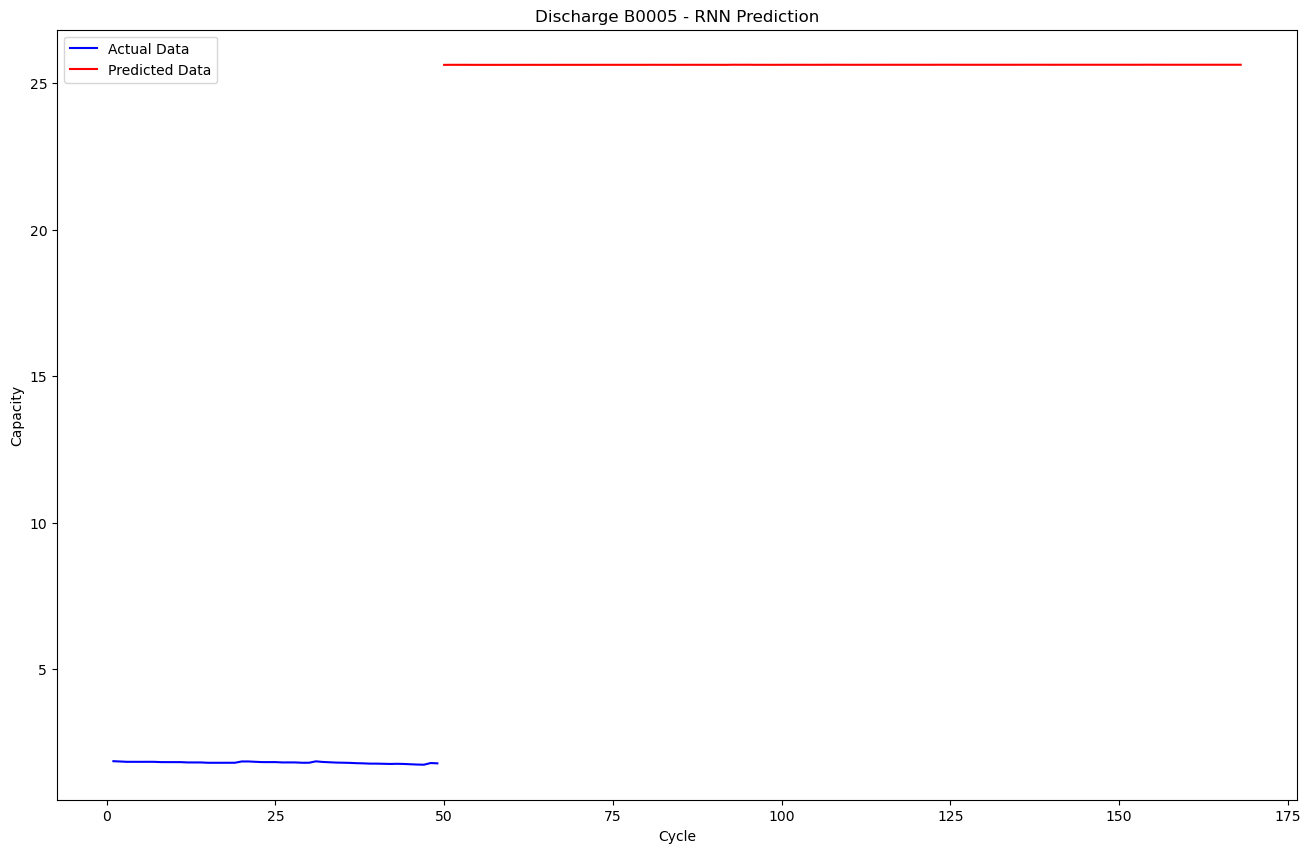

In [7]:
# 시각화
plt.figure(figsize=(16, 10))
plt.plot(range(1, 50), capacity_val['capacity'].iloc[:49], label="Actual Data", color='blue')
plt.plot(range(50, len(pred) + 50), pred, label="Predicted Data", color='red')
plt.xlabel('Cycle')
plt.ylabel('Capacity')
plt.legend()
plt.title('Discharge B0005 - RNN Prediction')
plt.show()